In [1]:
# %% [1]
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2024-12-17 18:12:28.566448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 18:12:29.017022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 18:12:29.166627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 18:12:29.209895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 18:12:29.486336: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# %% [2] Load and preprocess data
def load_data(filepath, train_ratio=0.7):
    """
    Load and preprocess data for GMDH algorithm.
    
    Args:
        filepath: Path to the data file
        train_ratio: Ratio for training set (default 0.7)
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Convert Time to datetime with explicit format (day first)
    df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')
    
    # Select features (excluding Location)
    feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 
                      'WD_10m', 'WD_100m', 'WG_10m', 'Power']
    
    # Create feature matrix
    data = df[feature_columns].values
    
    # Determine split indices
    total_samples = data.shape[0]
    train_end = int(train_ratio * total_samples)
    
    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:]
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit the scaler on training data (excluding the target column)
    scaled_train_features = scaler.fit_transform(train_data[:, :-1])
    scaled_val_features = scaler.transform(val_data[:, :-1])
    
    # Combine scaled features with target
    scaled_train_data = np.column_stack((scaled_train_features, train_data[:, -1]))
    scaled_val_data = np.column_stack((scaled_val_features, val_data[:, -1]))
    
    print("Data shapes after scaling and splitting:")
    print(f"Training data shape: {scaled_train_data.shape}")
    print(f"Validation data shape: {scaled_val_data.shape}")
    
    return scaled_train_data, scaled_val_data, scaler

In [3]:
# %% [3] Create sliding windows for GMDH
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data for GMDH.
    
    Args:
        data: numpy array of shape (n_samples, n_features)
        window_size: number of time steps to use for input
        target_col: index of target column (default: -1 for Power)
    
    Returns:
        X: numpy array of shape (n_samples - window_size, window_size, n_features)
        y: numpy array of shape (n_samples - window_size,)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size, target_col]
        
        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)

In [4]:
# %% [4] Main execution
if __name__ == "__main__":
    # Load and preprocess data
    train_data, val_data, scaler = load_data('../data/raw/Train.csv')
    
    # Create windows
    X_train, y_train = create_windows(train_data)
    X_val, y_val = create_windows(val_data)
    
    print("\nWindowed dataset shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_val:   {X_val.shape}")
    print(f"y_val:   {y_val.shape}")

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (42048, 9)

Windowed dataset shapes:
X_train: (98100, 12, 9)
y_train: (98100,)
X_val:   (42036, 12, 9)
y_val:   (42036,)


In [5]:
# %% [5] Updated PolynomialNeuron and fitting function with flattened inputs

import tensorflow as tf
import numpy as np

def fit_polynomial_neuron(X_train_in, y_train, feature_pair, polynomial_type):
    """
    Fit a polynomial neuron given two input variables (from flattened windowed input).
    X_train_in: shape (n_samples, W*F) where W is window_size and F is n_features.
    """
    i, j = feature_pair
    xi = X_train_in[:, i]
    xj = X_train_in[:, j]

    if polynomial_type == 'linear':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj
        ])
    elif polynomial_type == 'incomplete_quadratic':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j + A3*(x_i*x_j)
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj,
            xi * xj
        ])
    elif polynomial_type == 'full_quadratic':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j + A3*x_i*x_j + A4*x_i^2 + A5*x_j^2
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj,
            xi * xj,
            xi**2,
            xj**2
        ])
    else:
        raise ValueError("Unknown polynomial_type")

    coeffs, _, _, _ = np.linalg.lstsq(X_mat, y_train, rcond=None)
    return coeffs

class PolynomialNeuron:
    """
    Polynomial neuron now directly uses flattened inputs.
    """
    def __init__(self, feature_pair, coeffs, polynomial_type):
        self.feature_pair = feature_pair
        self.coeffs = coeffs
        self.polynomial_type = polynomial_type

    def predict(self, X):
        # X is (n_samples, W*F)
        i, j = self.feature_pair
        xi = X[:, i]
        xj = X[:, j]

        if self.polynomial_type == 'linear':
            A0, A1, A2 = self.coeffs
            return A0 + A1*xi + A2*xj
        elif self.polynomial_type == 'incomplete_quadratic':
            A0, A1, A2, A3 = self.coeffs
            return A0 + A1*xi + A2*xj + A3*(xi*xj)
        elif self.polynomial_type == 'full_quadratic':
            A0, A1, A2, A3, A4, A5 = self.coeffs
            return A0 + A1*xi + A2*xj + A3*(xi*xj) + A4*(xi**2) + A5*(xj**2)
        else:
            raise ValueError("Unknown polynomial_type")

In [6]:
# %% [6] Updated GMDHLayer

class GMDHCriteria:
    @staticmethod
    def regularity_criterion(y_true, y_pred, nb):
        return tf.reduce_sum(tf.square(y_true - y_pred)) / nb

    @staticmethod
    def unbiasedness_criterion(predictions1, predictions2, r1, r2):
        # Simple approach as before
        min_len = tf.minimum(tf.shape(predictions1)[0], tf.shape(predictions2)[0])
        predictions1 = predictions1[:min_len]
        predictions2 = predictions2[:min_len]
        return tf.reduce_sum(tf.square(predictions1 - predictions2)) / tf.cast(min_len, tf.float32)

    @staticmethod
    def combined_criterion(regularity, unbiasedness, alpha):
        return alpha * regularity + (1 - alpha) * unbiasedness


class GMDHLayer:
    def __init__(self, num_features, F=5, epsilon=1e-6, alpha=0.5, polynomial_type='full_quadratic'):
        self.num_features = num_features
        self.F = F
        self.epsilon = epsilon
        self.previous_criterion = None
        self.neurons = []
        self.feature_pairs = [(i, j) for i in range(num_features) for j in range(i+1, num_features)]
        self.alpha = alpha
        self.polynomial_type = polynomial_type

    def fit_layer(self, X_train, y_train):
        # Now X_train is already flattened: (n_samples, W*F)
        self.neurons = []
        for pair in self.feature_pairs:
            coeffs = fit_polynomial_neuron(X_train, y_train, pair, self.polynomial_type)
            neuron = PolynomialNeuron(feature_pair=pair, coeffs=coeffs, polynomial_type=self.polynomial_type)
            self.neurons.append(neuron)

    def predict_all(self, X):
        # X is flattened
        preds = [neuron.predict(X) for neuron in self.neurons]
        return np.column_stack(preds)

    def check_stopping_criterion(self, current_criterion):
        if self.previous_criterion is None:
            self.previous_criterion = current_criterion
            return False
        diff = abs(current_criterion - self.previous_criterion)
        self.previous_criterion = current_criterion
        return diff < self.epsilon

    def select_best_neurons(self, outputs_train, outputs_val, y_train, y_val):
        y_val_t = tf.convert_to_tensor(y_val, dtype=tf.float32)
        y_train_t = tf.convert_to_tensor(y_train, dtype=tf.float32)
        out_train_t = tf.convert_to_tensor(outputs_train, dtype=tf.float32)
        out_val_t = tf.convert_to_tensor(outputs_val, dtype=tf.float32)
        nb_val = len(y_val)

        criteria = []
        for i in range(outputs_val.shape[1]):
            reg = GMDHCriteria.regularity_criterion(y_val_t, out_val_t[:, i], nb_val)
            unbias = GMDHCriteria.unbiasedness_criterion(out_train_t[:, i], out_val_t[:, i],
                                                         len(y_train), len(y_val))
            combined = GMDHCriteria.combined_criterion(reg, unbias, self.alpha)
            criteria.append(combined)

        criteria_tensor = tf.stack(criteria)
        best_indices = tf.argsort(criteria_tensor)[:self.F]
        return best_indices.numpy()

In [7]:
# %% [7] Updated GMDHModel

class GMDHModel:
    def __init__(self, input_dim, max_layers=5, F=5, epsilon=1e-6, alpha=0.5, polynomial_type='full_quadratic'):
        self.max_layers = max_layers
        self.F = F
        self.epsilon = epsilon
        self.alpha = alpha
        self.input_dim = input_dim  # Now this is W*F after flattening
        self.polynomial_type = polynomial_type
        self.godel_numbers = {}
        self.gmdh_layers = []
        self.best_neurons_per_layer = []
        # For reconstructing final expression
        self.feature_expressions = {i: f"X_{i}" for i in range(input_dim)}

        self.history = {
            'layer_criteria': [],
            'regularity_criteria': [],
            'unbiasedness_criteria': [],
            'layer_outputs_train': [],
            'layer_outputs_val': [],
            'selected_neurons': [],
            'layer_losses_train': [],
            'layer_losses_val': []
        }

    def train_layer(self, X_train, y_train, X_val, y_val, layer_idx):
        layer = GMDHLayer(num_features=X_train.shape[-1], F=self.F, epsilon=self.epsilon, alpha=self.alpha, polynomial_type=self.polynomial_type)
        self.gmdh_layers.append(layer)

        # Fit neurons
        layer.fit_layer(X_train, y_train)

        # Compute outputs
        outputs_train = layer.predict_all(X_train)
        outputs_val = layer.predict_all(X_val)

        nb_val = len(y_val)
        y_val_t = tf.convert_to_tensor(y_val, dtype=tf.float32)
        y_train_t = tf.convert_to_tensor(y_train, dtype=tf.float32)
        out_train_t = tf.convert_to_tensor(outputs_train, dtype=tf.float32)
        out_val_t = tf.convert_to_tensor(outputs_val, dtype=tf.float32)

        reg_criteria = []
        unbias_criteria = []
        combined_criteria = []

        for i in range(outputs_train.shape[1]):
            reg = GMDHCriteria.regularity_criterion(y_val_t, out_val_t[:, i], nb_val)
            unb = GMDHCriteria.unbiasedness_criterion(out_train_t[:, i], out_val_t[:, i],
                                                      len(y_train), len(y_val))
            comb = GMDHCriteria.combined_criterion(reg, unb, self.alpha)
            reg_criteria.append(reg.numpy())
            unbias_criteria.append(unb.numpy())
            combined_criteria.append(comb.numpy())

        # Select best neurons
        best_indices = layer.select_best_neurons(outputs_train, outputs_val, y_train, y_val)
        self.best_neurons_per_layer.append(best_indices)

        self.history['layer_criteria'].append(combined_criteria)
        self.history['regularity_criteria'].append(reg_criteria)
        self.history['unbiasedness_criteria'].append(unbias_criteria)
        self.history['layer_outputs_train'].append(outputs_train)
        self.history['layer_outputs_val'].append(outputs_val)
        self.history['selected_neurons'].append(best_indices)

        y_train_2d = y_train[:, np.newaxis]
        y_val_2d = y_val[:, np.newaxis]
        train_loss = np.mean((y_train_2d - outputs_train)**2)
        val_loss = np.mean((y_val_2d - outputs_val)**2)
        self.history['layer_losses_train'].append(train_loss)
        self.history['layer_losses_val'].append(val_loss)

        # Update expressions
        if layer_idx == 0:
            prev_features = self.feature_expressions
        else:
            prev_features = self.feature_expressions

        new_feature_expressions = {}
        for i, neuron_idx in enumerate(best_indices):
            neuron = layer.neurons[neuron_idx]
            fp = neuron.feature_pair
            f1_expr = self.feature_expressions[fp[0]]
            f2_expr = self.feature_expressions[fp[1]]

            if self.polynomial_type == 'linear':
                A0, A1, A2 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr})"
            elif self.polynomial_type == 'incomplete_quadratic':
                A0, A1, A2, A3 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr} + {A3:.4f}*({f1_expr}*{f2_expr}))"
            elif self.polynomial_type == 'full_quadratic':
                A0, A1, A2, A3, A4, A5 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr} + {A3:.4f}*({f1_expr}*{f2_expr}) + {A4:.4f}*({f1_expr}^2) + {A5:.4f}*({f2_expr}^2))"
            else:
                raise ValueError("Unknown polynomial_type")

            new_feature_expressions[i] = expr

        self.feature_expressions = new_feature_expressions
        current_criterion = np.mean([combined_criteria[i] for i in best_indices])
        return layer.check_stopping_criterion(current_criterion)

    def synthesize(self, X_train, y_train, X_val, y_val):
        current_X_train = X_train
        current_X_val = X_val

        for layer_idx in range(self.max_layers):
            print(f"Synthesizing layer {layer_idx + 1}")
            should_stop = self.train_layer(current_X_train, y_train, current_X_val, y_val, layer_idx)
            if should_stop:
                print(f"Stopping criterion met at layer {layer_idx + 1}")
                break

            last_layer = self.gmdh_layers[-1]
            outputs_train = last_layer.predict_all(current_X_train)
            outputs_val = last_layer.predict_all(current_X_val)
            best_indices = self.best_neurons_per_layer[-1]

            # Update the input for the next layer (now just one dimension)
            current_X_train = outputs_train[:, best_indices]
            current_X_val = outputs_val[:, best_indices]

    def predict(self, X):
        x = X
        for layer_idx, layer in enumerate(self.gmdh_layers):
            out = layer.predict_all(x)
            best_indices = self.best_neurons_per_layer[layer_idx]
            out = out[:, best_indices]
            x = out
        return out

    def get_final_model_expression(self):
        return list(self.feature_expressions.values())

In [8]:
# %% [8] Updated main execution

if __name__ == "__main__":
    # Load and preprocess data
    train_data, val_data, scaler = load_data('../data/raw/Train.csv')
    
    # Create windows
    X_train, y_train = create_windows(train_data)
    X_val, y_val = create_windows(val_data)
    
    # Flatten the windowed data: 
    # If X_train is (N, W, F), flatten to (N, W*F)
    N_train, W, F = X_train.shape
    X_train_flat = X_train.reshape(N_train, W*F)
    N_val = X_val.shape[0]
    X_val_flat = X_val.reshape(N_val, W*F)

    # Initialize and train model with given alpha and polynomial_type
    model = GMDHModel(input_dim=X_train_flat.shape[-1], max_layers=5, F=5, epsilon=1e-6, alpha=0.5, polynomial_type='full_quadratic')
    
    # Train the model
    model.synthesize(X_train_flat, y_train, X_val_flat, y_val)
    
    # Print final layer performance
    print("\nFinal Layer Performance:")
    print("Training Loss:", model.history['layer_losses_train'][-1])
    print("Validation Loss:", model.history['layer_losses_val'][-1])
    
    # Example predictions
    predictions = model.predict(X_val_flat)
    predictions_mean = predictions.mean(axis=1)
    print("\nSample Predictions:", predictions_mean[:5])

    # Print final model expression
    print("\nFinal Model Expression(s):")
    final_expressions = model.get_final_model_expression()
    for expr in final_expressions:
        print(expr)

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (42048, 9)
Synthesizing layer 1


I0000 00:00:1734459187.632399   26327 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734459187.991526   26327 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734459187.991565   26327 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734459187.994196   26327 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734459187.994225   26327 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Synthesizing layer 2
Synthesizing layer 3
Synthesizing layer 4
Synthesizing layer 5

Final Layer Performance:
Training Loss: 0.06642472381272448
Validation Loss: 0.06197906848603543

Sample Predictions: [0.33616422 0.33052677 0.32946309 0.33233502 0.33524409]

Final Model Expression(s):
(-0.0689 + 4.4963*(-0.0080 + -1.6160*(0.2764 + -2.4269*(0.4182 + -1.6993*(0.3487 + -0.0077*X_1 + -0.0107*X_10 + 0.0639*(X_1*X_10) + -0.0211*(X_1^2) + -0.0471*(X_10^2)) + 0.1278*(0.3513 + -0.0116*X_10 + -0.0075*X_19 + 0.0769*(X_10*X_19) + -0.0277*(X_10^2) + -0.0556*(X_19^2)) + -14.0117*((0.3487 + -0.0077*X_1 + -0.0107*X_10 + 0.0639*(X_1*X_10) + -0.0211*(X_1^2) + -0.0471*(X_10^2))*(0.3513 + -0.0116*X_10 + -0.0075*X_19 + 0.0769*(X_10*X_19) + -0.0277*(X_10^2) + -0.0556*(X_19^2))) + 9.8598*((0.3487 + -0.0077*X_1 + -0.0107*X_10 + 0.0639*(X_1*X_10) + -0.0211*(X_1^2) + -0.0471*(X_10^2))^2) + 8.0786*((0.3513 + -0.0116*X_10 + -0.0075*X_19 + 0.0769*(X_10*X_19) + -0.0277*(X_10^2) + -0.0556*(X_19^2))^2)) + 1.7910*(0

Validation R²: -0.1957829767316437
Validation MSE: 0.06196580352912394
Validation MAE: 0.216240042256553


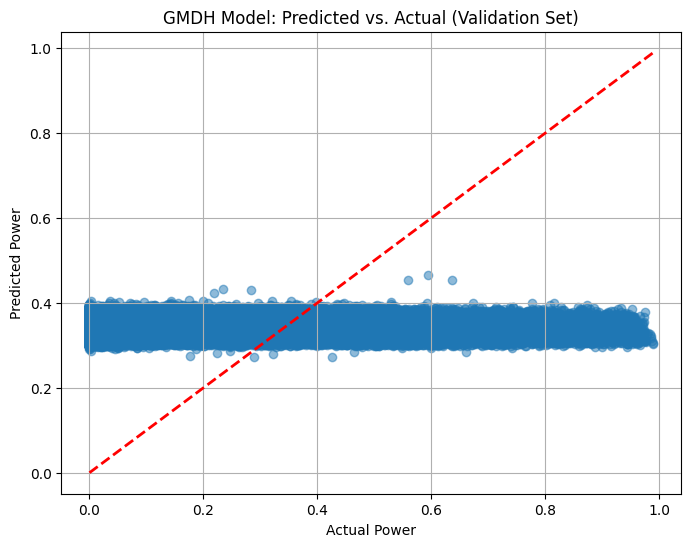

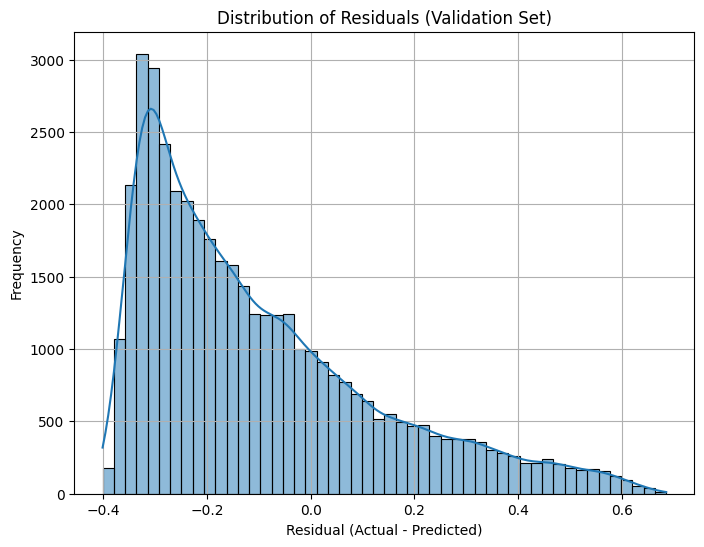

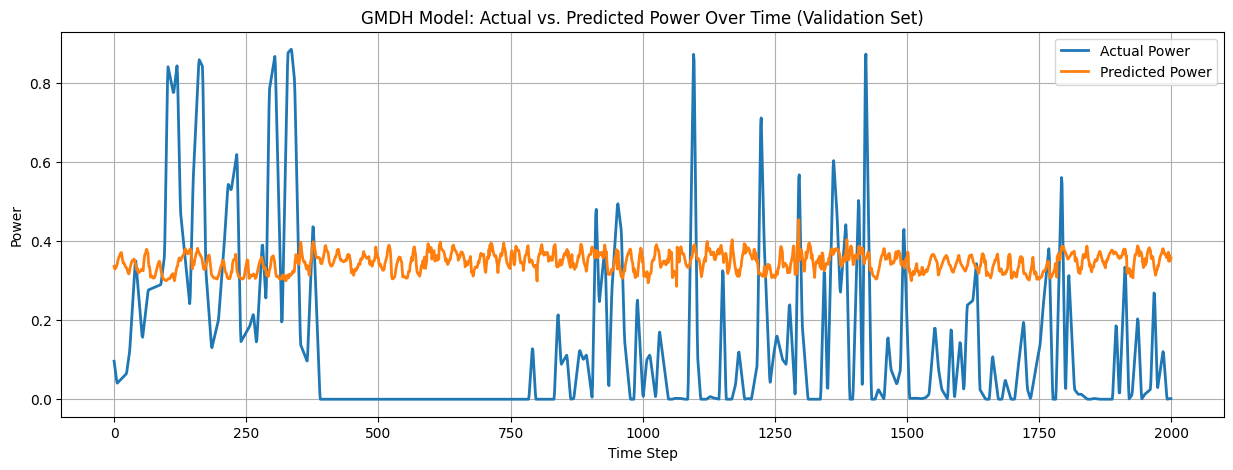

In [10]:
# %% [9] Evaluation and Visualization for GMDH Model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Since the model expects flattened inputs, ensure we use X_val_flat:
# If X_val_flat is not defined here, we can flatten X_val:
# X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Get predictions from the model
predictions_val = model.predict(X_val_flat)  # shape: (n_samples, F)
predictions_val_mean = predictions_val.mean(axis=1)  # Average across neurons

# Compute validation metrics
r2_val = r2_score(y_val, predictions_val_mean)
mse_val = mean_squared_error(y_val, predictions_val_mean)
mae_val = mean_absolute_error(y_val, predictions_val_mean)

print("Validation R²:", r2_val)
print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)

# Scatter Plot: Predicted vs Actual (Validation Set)
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions_val_mean, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('GMDH Model: Predicted vs. Actual (Validation Set)')
plt.grid(True)
plt.show()

# Residual Distribution
residuals_val = y_val - predictions_val_mean
plt.figure(figsize=(8,6))
sns.histplot(residuals_val, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Validation Set)')
plt.grid(True)
plt.show()

# Line Plot: Actual vs Predicted Over Time (Validation Set)
start_idx = 0
end_idx = min(2000, len(y_val))  # adjust as needed
plt.figure(figsize=(15,5))
plt.plot(range(start_idx, end_idx), y_val[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), predictions_val_mean[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('GMDH Model: Actual vs. Predicted Power Over Time (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()